In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(786.5), np.float64(593.5), np.float64(-0.5))

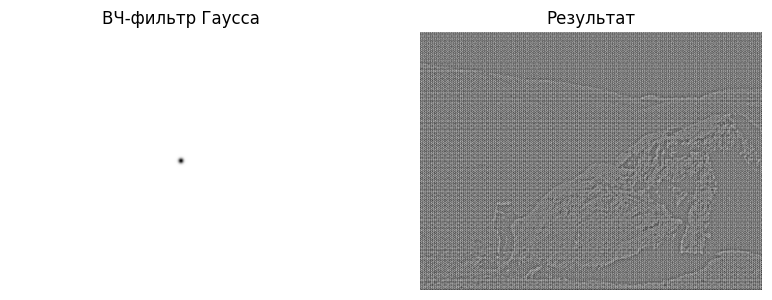

In [9]:
sigma=4.0

kernel_size=None
    
def gaussian_highpass_filter(shape, sigma):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u, v, indexing='ij')

    d = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    h = 1 - np.exp(-(d**2) / (2 * (sigma**2)))
    return h

if kernel_size is None:
        kernel_size = int(6 * sigma) + 1
        if kernel_size % 2 == 0:
            kernel_size += 1
hp_filter = gaussian_highpass_filter(img.shape, sigma)
gaussian_kernel = cv.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2d = gaussian_kernel * gaussian_kernel.T
    
low_pass = cv.filter2D(img, -1, gaussian_kernel_2d)
    
high_pass = img.astype(np.float32) - low_pass.astype(np.float32)
    
high_pass_normalized = cv.normalize(high_pass, None, 0, 255, cv.NORM_MINMAX)
high_pass_uint8 = np.uint8(high_pass_normalized)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.imshow(hp_filter, cmap='gray')
plt.title('ВЧ-фильтр Гаусса')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(high_pass, cmap='gray')
plt.title('Результат')
plt.axis('off')

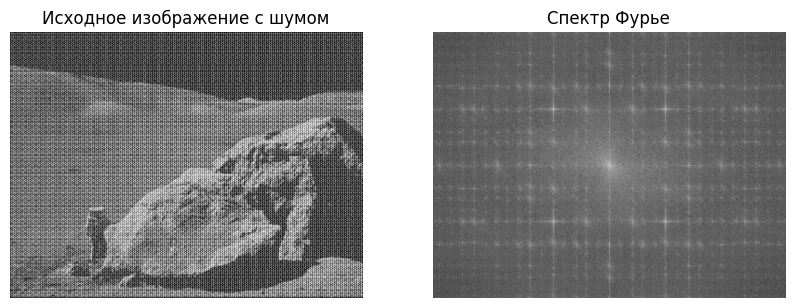

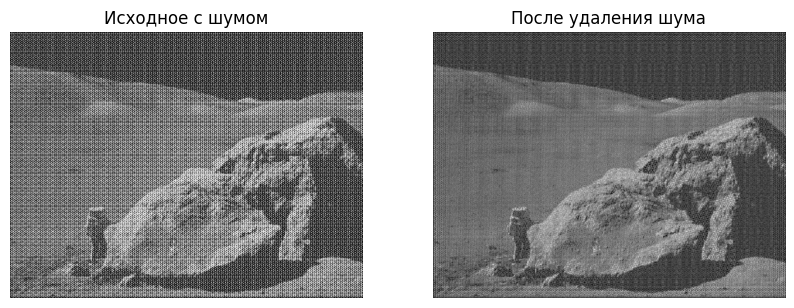

In [4]:
from skimage.feature import peak_local_max

dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение с шумом')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр Фурье')
plt.axis('off')
plt.show()

local_maxima = peak_local_max(magnitude_spectrum, min_distance=20, threshold_abs=180)

rows, cols = img.shape
mask = np.ones((rows, cols, 2), dtype=np.float32)
center_x, center_y = rows//2, cols//2

for peak in local_maxima:
    y, x = peak
    distance = np.sqrt((x - center_y)**2 + (y - center_x)**2)
    if distance > 40:  
        cv.circle(mask, (x, y), 5, (0, 0), -1)

dft_shift_filtered = dft_shift * mask

f_ishift = np.fft.ifftshift(dft_shift_filtered)
image_idft = cv.idft(f_ishift)
image_idft = cv.magnitude(image_idft[:,:,0], image_idft[:,:,1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное с шумом')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_idft, cmap='gray')
plt.title('После удаления шума')
plt.axis('off')
plt.show()
